<a href="https://colab.research.google.com/github/t1masavin/my_resume/blob/master/AI_Cup_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
from random import randint
import json

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['staphylococcus_epidermidis', 'klebsiella_pneumoniae', 
               'staphylococcus_aureus', 'moraxella_catarrhalis', 'c_kefir', 'ent_cloacae', 'back']
    dec_CLASSES ={'staphylococcus_epidermidis' : 0, 'klebsiella_pneumoniae' :1, 
          'staphylococcus_aureus' : 2, 'moraxella_catarrhalis' : 3, 
          'c_kefir' : 4, 'ent_cloacae' : 5, 'back' : 6}
    
    def __init__(
            self, 
#             images_dir, 
#             masks_dir,
            mode = 1,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.sol_df = pd.read_csv(r"C:\Users\GPU\Desktop\project\solution_6.csv")
        self.mode = mode
        if self.mode == 1: 
            self.ids = list(range(1,261 + 1
                              # + 108
                              ))
        else:
            self.ids = list(range(1, 108))
   
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
     
        image, mask = self.get_img(self.ids[i])
        
        
#         apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
#         apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image.astype('float32'), mask.astype(int)
    
    def get_img(self, i):
        if self.mode == 2:
            pth_m = r"C:\Users\GPU\Desktop\project\TRAIN\train_masks_2\{}.png".format(str(i).zfill(3))
            pth_i = r"C:\Users\GPU\Desktop\project\test\{}.png".format(str(i).zfill(3))
            choise = 128
            move = 0
            class_ = self.dec_CLASSES[self.sol_df.loc[self.sol_df['id'] == i, 'class'][i-1]]
            
            image = cv2.imread(pth_i)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image[:,choise:640-move,:]
            mask = cv2.imread(pth_m, 0)

            # extract certain classes from mask (e.g. cars)
            masks = [self.masking(class_, v, mask) for v in self.class_values]
            masks = np.stack(masks, axis=-1).astype('float')    
            return image/255, masks/255

        elif self.mode == 1:
            pth_m = r"C:\Users\GPU\Desktop\project\TRAIN\train_masks\{}.png".format(str(i).zfill(3))
            pth_i = r"C:\Users\GPU\Desktop\project\train_with_json\{}".format(str(i).zfill(3))
            pth_i_j = pth_i + r".json"
            pth_i = pth_i + r".png"
            choise = randint(0, 128)
            move = 128 - choise   
            class_ = json.load(open(pth_i_j))
            class_ = self.dec_CLASSES[class_['shapes'][0]['label']]
        else:
            pth_m = r"C:\Users\GPU\Desktop\project\TRAIN\train_masks_2\{}.png".format(str(i).zfill(3))
            pth_i = r"C:\Users\GPU\Desktop\project\test\{}.png".format(str(i).zfill(3))
            choise = 0
            move = 128
            class_ = self.dec_CLASSES[self.sol_df.loc[self.sol_df['id'] == i, 'class'][i-1]]
            

        image = cv2.imread(pth_i)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image[:,choise:640-move,:]
        mask = cv2.imread(pth_m, 0)
        mask = mask[:,choise:640-move]

        # extract certain classes from mask (e.g. cars)
        masks = [self.masking(class_, v, mask) for v in self.class_values]
        masks = np.stack(masks, axis=-1).astype('float')    
        return image/255, masks/255
    
    def masking(self, class_, v, mask):
        if class_ == v:
            return mask
        elif v == 6:
            m = np.ones((512,512)) * 255 - np.asarray(mask)
            return m
        else:
            return np.zeros((512,512))
        
    def __len__(self):
        return len(self.ids)

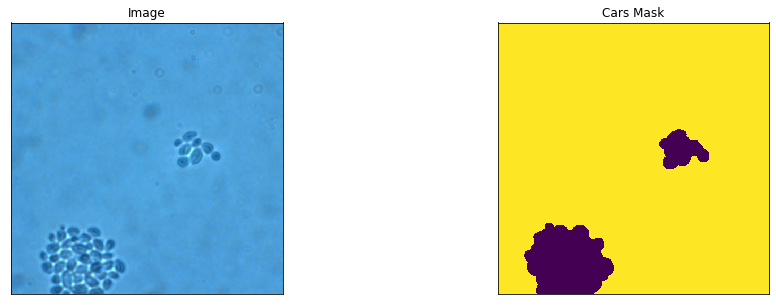

In [ ]:
# Lets look at data we have

dataset = Dataset(
#     x_train_dir, y_train_dir, 
    mode = 1,
    classes=['staphylococcus_epidermidis', 'klebsiella_pneumoniae', 
               'staphylococcus_aureus', 'moraxella_catarrhalis', 'c_kefir', 'ent_cloacae', 'back'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask[:,:,6].squeeze(),
)

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [
                   albu.GridDistortion(p=0.3),
                   albu.Flip(p=0.5),
                   albu.Transpose(p=0.3),
                   albu.GridDistortion(p=0.4),
                   albu.Transpose(p=0.5),
                   albu.Flip(p=0.5)
    ]
    return  albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Flip(),
        albu.Transpose(p=0.5),
        albu.GridDistortion(p=0.4),
    ]
    return albu.Compose(test_transform)

def get_test_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
#         albu.Flip()
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
#         albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

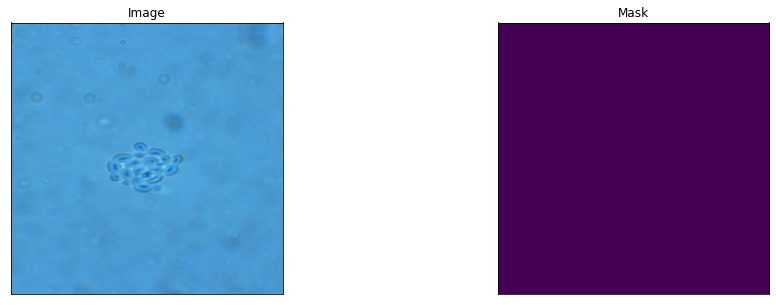

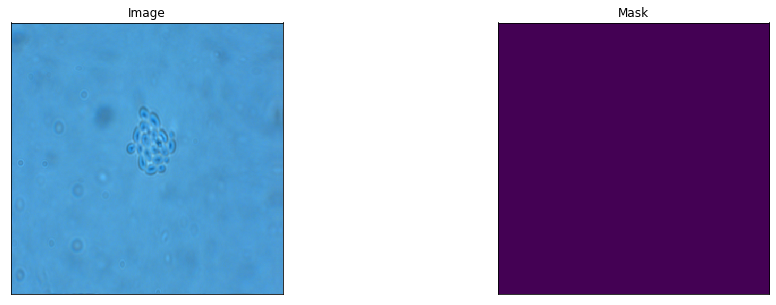

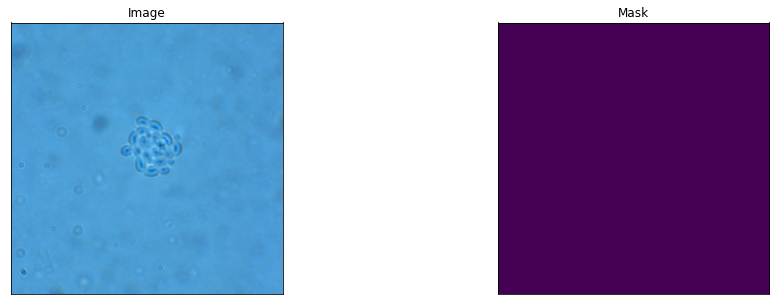

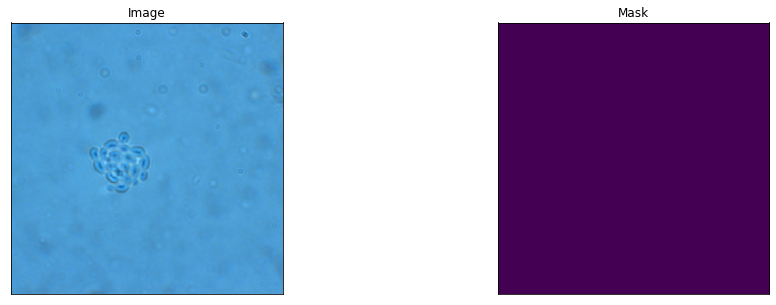

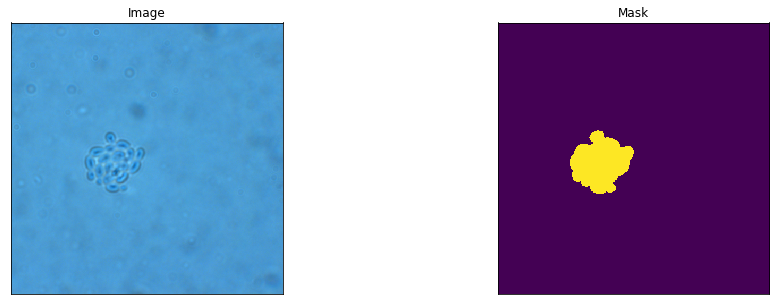

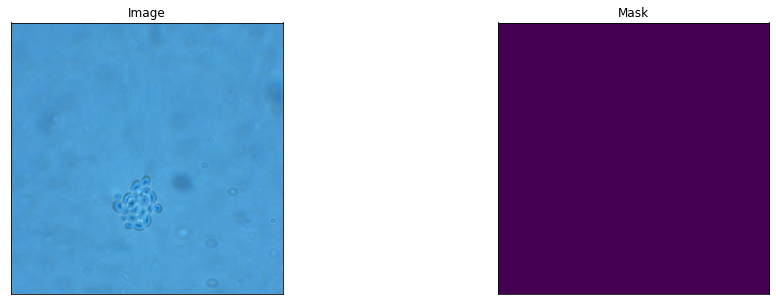

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
#     x_train_dir, 
#     y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['staphylococcus_epidermidis', 'klebsiella_pneumoniae', 
               'staphylococcus_aureus', 'moraxella_catarrhalis', 'c_kefir', 'ent_cloacae'],
)

# same image with different random transforms
for i in range(6):
    image, mask = augmented_dataset[30]
    visualize(image=image, mask=mask[:,:,i].squeeze())

## Create model and train

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['staphylococcus_epidermidis', 'klebsiella_pneumoniae', 
               'staphylococcus_aureus', 'moraxella_catarrhalis', 'c_kefir', 'ent_cloacae', 'back']
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER)

In [ ]:
train_dataset = Dataset(
#     x_train_dir, 
#     y_train_dir, 
    mode = 1,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
#     x_valid_dir, 
#     y_valid_dir, 
    mode = 0,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, 
#                           num_workers=12
                         )
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False,
#                           num_workers=4
                         )

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.JaccardLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
#     verbose=True,
)


valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
#     verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 1100):
    
    print('\nEpoch: {}'.format(i))
    if i <= 900:
        train_logs = train_epoch.run(train_loader)
    else:
        train_logs = train_epoch.run(valid_loader)
    if i% 200 == 0:
        optimizer.param_groups[0]['lr'] /=10
    if i%10 == 0 or i > 900:
        
        valid_logs = valid_epoch.run(valid_loader)

        # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')



Epoch: 0
valid: 100%|█████████████████████████████| 107/107 [00:16<00:00,  6.63it/s, jaccard_loss - 0.8237, iou_score - 0.08534]
Model saved!

Epoch: 1
train: 100%|████████████████████████████████| 33/33 [00:51<00:00,  1.55s/it, jaccard_loss - 0.8158, iou_score - 0.1134]

Epoch: 2
train: 100%|████████████████████████████████| 33/33 [00:52<00:00,  1.58s/it, jaccard_loss - 0.8035, iou_score - 0.1579]

Epoch: 3
train: 100%|████████████████████████████████| 33/33 [00:50<00:00,  1.53s/it, jaccard_loss - 0.7962, iou_score - 0.1963]

Epoch: 4
train: 100%|████████████████████████████████| 33/33 [00:50<00:00,  1.54s/it, jaccard_loss - 0.7835, iou_score - 0.2458]

Epoch: 5
train: 100%|████████████████████████████████| 33/33 [00:50<00:00,  1.54s/it, jaccard_loss - 0.7733, iou_score - 0.2899]

Epoch: 6
train: 100%|████████████████████████████████| 33/33 [00:50<00:00,  1.53s/it, jaccard_loss - 0.7619, iou_score - 0.3303]

Epoch: 7
train: 100%|████████████████████████████████| 33/33 [00:50<00:00,  

train: 100%|████████████████████████████████| 33/33 [00:50<00:00,  1.52s/it, jaccard_loss - 0.2733, iou_score - 0.9624]

Epoch: 57
train: 100%|█████████████████████████████████| 33/33 [00:50<00:00,  1.54s/it, jaccard_loss - 0.266, iou_score - 0.9647]

Epoch: 58
train: 100%|████████████████████████████████| 33/33 [00:51<00:00,  1.55s/it, jaccard_loss - 0.2586, iou_score - 0.9659]

Epoch: 59
train: 100%|█████████████████████████████████| 33/33 [00:51<00:00,  1.56s/it, jaccard_loss - 0.2509, iou_score - 0.967]

Epoch: 60
valid: 100%|██████████████████████████████| 107/107 [00:17<00:00,  6.18it/s, jaccard_loss - 0.2431, iou_score - 0.9661]
Model saved!

Epoch: 61
train: 100%|████████████████████████████████| 33/33 [00:50<00:00,  1.53s/it, jaccard_loss - 0.2376, iou_score - 0.9677]

Epoch: 62
train: 100%|████████████████████████████████| 33/33 [00:50<00:00,  1.54s/it, jaccard_loss - 0.2301, iou_score - 0.9687]

Epoch: 63
train: 100%|████████████████████████████████| 33/33 [00:51<00:00,  1.5

train: 100%|███████████████████████████████| 33/33 [00:51<00:00,  1.55s/it, jaccard_loss - 0.07601, iou_score - 0.9827]

Epoch: 113
train: 100%|████████████████████████████████| 33/33 [00:50<00:00,  1.53s/it, jaccard_loss - 0.0736, iou_score - 0.9839]

Epoch: 114
train: 100%|███████████████████████████████| 33/33 [00:51<00:00,  1.57s/it, jaccard_loss - 0.07236, iou_score - 0.9848]

Epoch: 115
train: 100%|███████████████████████████████| 33/33 [00:51<00:00,  1.57s/it, jaccard_loss - 0.07057, iou_score - 0.9853]

Epoch: 116
train: 100%|███████████████████████████████| 33/33 [00:51<00:00,  1.57s/it, jaccard_loss - 0.06934, iou_score - 0.9851]

Epoch: 117
train: 100%|████████████████████████████████| 33/33 [00:50<00:00,  1.54s/it, jaccard_loss - 0.0678, iou_score - 0.9859]

Epoch: 118
train: 100%|███████████████████████████████| 33/33 [00:50<00:00,  1.54s/it, jaccard_loss - 0.06611, iou_score - 0.9864]

Epoch: 119
train: 100%|███████████████████████████████| 33/33 [00:51<00:00,  1.57s/it, 

train: 100%|███████████████████████████████| 33/33 [00:51<00:00,  1.57s/it, jaccard_loss - 0.02963, iou_score - 0.9892]

Epoch: 170
valid: 100%|██████████████████████████████| 107/107 [00:17<00:00,  6.20it/s, jaccard_loss - 0.03345, iou_score - 0.984]
Model saved!

Epoch: 171
train: 100%|███████████████████████████████| 33/33 [00:52<00:00,  1.59s/it, jaccard_loss - 0.02891, iou_score - 0.9891]

Epoch: 172
train: 100%|███████████████████████████████| 33/33 [00:50<00:00,  1.54s/it, jaccard_loss - 0.02913, iou_score - 0.9891]

Epoch: 173
train: 100%|████████████████████████████████| 33/33 [00:50<00:00,  1.54s/it, jaccard_loss - 0.0283, iou_score - 0.9892]

Epoch: 174
train: 100%|█████████████████████████████████| 33/33 [00:50<00:00,  1.53s/it, jaccard_loss - 0.028, iou_score - 0.9895]

Epoch: 175
train: 100%|███████████████████████████████| 33/33 [00:50<00:00,  1.54s/it, jaccard_loss - 0.02811, iou_score - 0.9895]

Epoch: 176
train: 100%|███████████████████████████████| 33/33 [00:50<00:00

train: 100%|█████████████████████████████████| 33/33 [00:51<00:00,  1.56s/it, jaccard_loss - 0.02131, iou_score - 0.99]

Epoch: 226
train: 100%|███████████████████████████████| 33/33 [00:50<00:00,  1.54s/it, jaccard_loss - 0.02151, iou_score - 0.9899]

Epoch: 227
train: 100%|████████████████████████████████| 33/33 [00:51<00:00,  1.56s/it, jaccard_loss - 0.0216, iou_score - 0.9897]

Epoch: 228
train: 100%|████████████████████████████████| 33/33 [00:51<00:00,  1.56s/it, jaccard_loss - 0.0225, iou_score - 0.9895]

Epoch: 229
train: 100%|███████████████████████████████| 33/33 [00:51<00:00,  1.55s/it, jaccard_loss - 0.02189, iou_score - 0.9898]

Epoch: 230
valid: 100%|███████████████████████████████| 107/107 [00:17<00:00,  6.23it/s, jaccard_loss - 0.0258, iou_score - 0.985]

Epoch: 231
train: 100%|███████████████████████████████| 33/33 [00:52<00:00,  1.58s/it, jaccard_loss - 0.02166, iou_score - 0.9898]

Epoch: 232
train: 100%|███████████████████████████████| 33/33 [00:52<00:00,  1.59s/it, 

## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    mode=0,
    augmentation=get_test_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)
test_dataset1 = Dataset(
    mode=2,
    augmentation=get_test_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|█████████████████████████████| 107/107 [00:13<00:00,  8.13it/s, jaccard_loss - 0.01388, iou_score - 0.9875]


## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
#     x_test_dir, y_test_dir, 
    mode=0,
    classes=CLASSES,
)

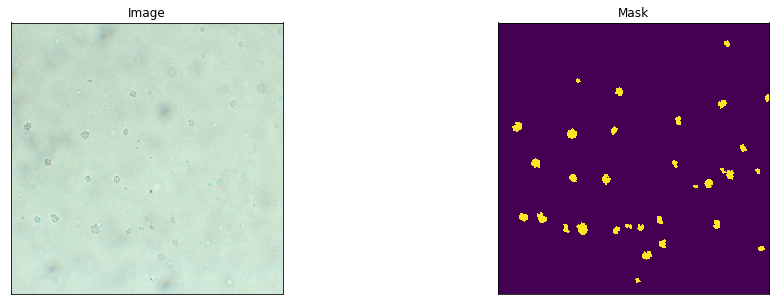

In [ ]:
image, mask = test_dataset_vis[30]
visualize(image=image, mask=mask[:,:,3].squeeze())

In [ ]:
image.shape

(512, 512, 3)

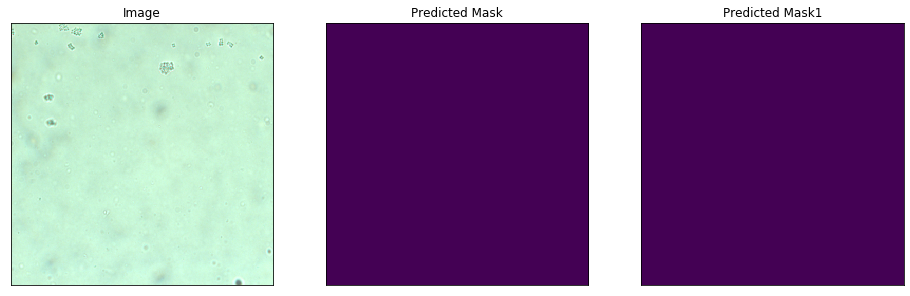

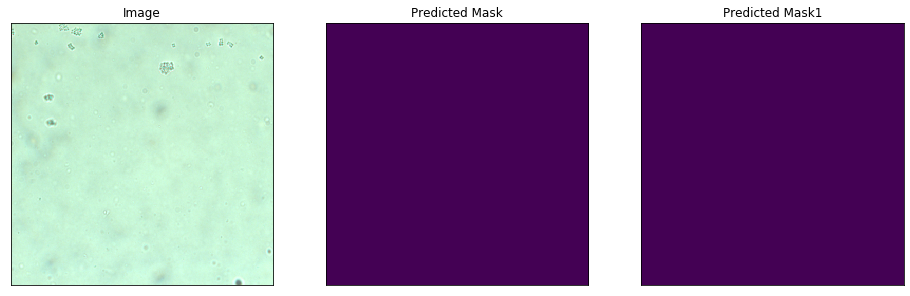

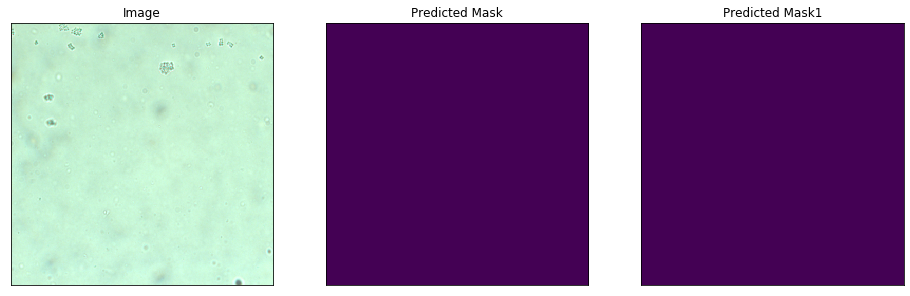

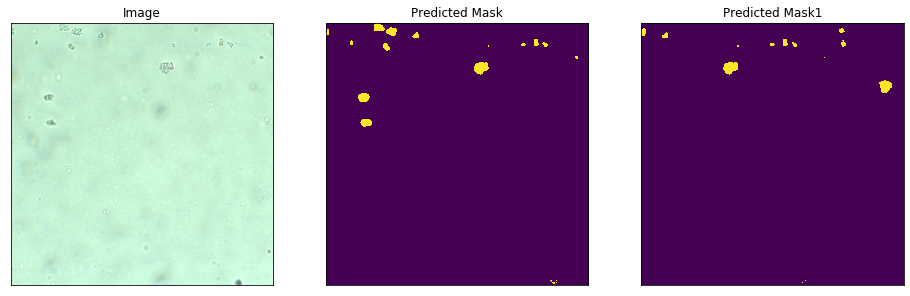

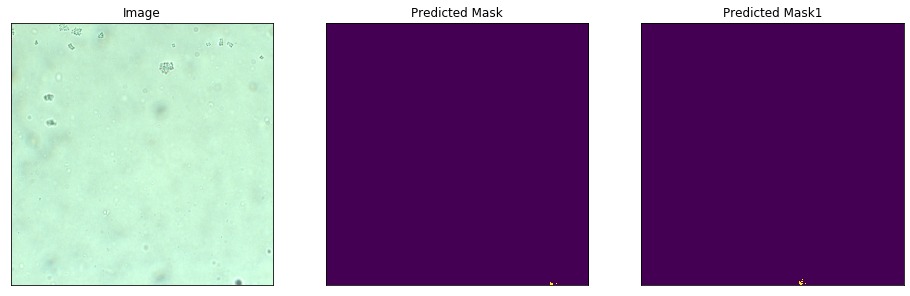

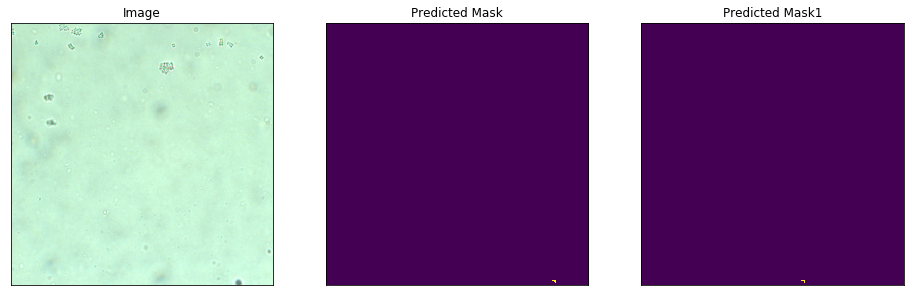

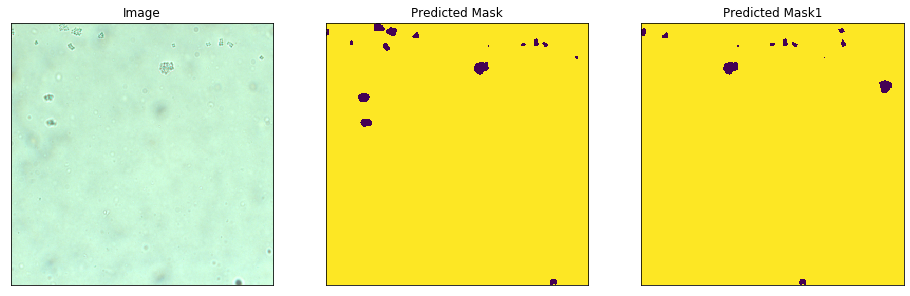

In [ ]:
n = 0

image, gt_mask = test_dataset[n]
image1, gt_mask1 = test_dataset1[n]

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

x_tensor1 = torch.from_numpy(image1).to(DEVICE).unsqueeze(0)

pr_mask1 = best_model.predict(x_tensor1)
pr_mask1 = (pr_mask1.squeeze().cpu().numpy().round())

zeros = np.zeros((7,512,640))
zeros[:,:, 128 :] = pr_mask1
zeros[:,:, : - 128] = pr_mask
for i in range(7):
        
    visualize(
        image=image.transpose(1,2,0), 
        predicted_mask=pr_mask[i],
        predicted_mask1=pr_mask1[i],
        
    )

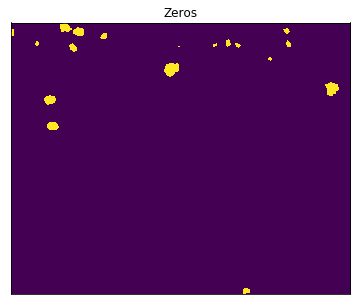

In [ ]:
visualize(zeros = zeros[6]*-1 + 1)

In [ ]:
import imageio

In [ ]:
for i in range(107):
    image, gt_mask = test_dataset[i]
    image1, gt_mask1 = test_dataset1[i]

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    x_tensor1 = torch.from_numpy(image1).to(DEVICE).unsqueeze(0)

    pr_mask1 = best_model.predict(x_tensor1)
    pr_mask1 = (pr_mask1.squeeze().cpu().numpy().round())
    pth = r'C:\Users\GPU\Desktop\project\pred_with_leak\{}.png'.format(str(i+1).zfill(3))
    zeros = np.zeros((7,512,640))
    zeros[:,:, 128 :] = pr_mask1
    zeros[:,:, : - 128] = pr_mask
    zeros = zeros[6]*(-1) + 1
    imageio.imwrite('C:\\Users\\GPU\\Desktop\\project\\pred_with_leak\\{}.png'.format(str(i+1).zfill(3)),zeros)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [ ]:
import base64

In [ ]:
sol_df = pd.read_csv(r'C:\Users\GPU\Desktop\project\solution_6.csv')
for i in range(1,108):
    with open('C:\\Users\\GPU\\Desktop\\project\\pred_with_leak\\{}.png'.format(str(i).zfill(3)), 'rb') as img_file:
        encoded_string = base64.b64encode(img_file.read())
        sol_df.loc[sol_df['id'] == i,'base64 encoded PNG (mask)'] = encoded_string.decode('utf-8')

In [ ]:
sol_df.to_csv(r'C:\Users\GPU\Desktop\project\solution_l.csv', index=False)

In [ ]:
zeros.shape

(512, 640)

In [ ]:
sol_df.head()

,id,class,base64 encoded PNG (mask)
0,1,staphylococcus_epidermidis,iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAYAAAASfd37AA...
1,2,staphylococcus_epidermidis,iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAYAAAASfd37AA...
2,3,ent_cloacae,iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAYAAAASfd37AA...
3,4,ent_cloacae,iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAYAAAASfd37AA...
4,5,ent_cloacae,iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAYAAAASfd37AA...


In [ ]:
sol_df.iloc[106]

id                                                                         107
class                                                              ent_cloacae
base64 encoded PNG (mask)    iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAYAAAASfd37AA...
Name: 106, dtype: object

In [ ]:
np.max(zeros)

1.0